# MACD histogram trading strategy

1. MACD histogram bar must have fallen 4 days in a row
2. The 4th last bar must be below 0
3. The current close must be lower than the day before close
4. Entry price is the current close
5. Exit on the first day when close is higher than the day before close

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Importing the dataset
data = pd.read_csv('./Candle_data/^NSEI-MAX.csv', index_col=0, parse_dates=True)
data = data.dropna()
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

print(data.head())
print('#' * 30)
print(data.tail())
print('#' * 30)
print(data.info())

                   Open         High          Low        Close  Volume
Date                                                                  
2007-09-17  4518.450195  4549.049805  4482.850098  4494.649902     0.0
2007-09-18  4494.100098  4551.799805  4481.549805  4546.200195     0.0
2007-09-19  4550.250000  4739.000000  4550.250000  4732.350098     0.0
2007-09-20  4734.850098  4760.850098  4721.149902  4747.549805     0.0
2007-09-21  4752.950195  4855.700195  4733.700195  4837.549805     0.0
##############################
                    Open          High           Low         Close    Volume
Date                                                                        
2023-12-04  20601.949219  20702.650391  20507.750000  20686.800781  381100.0
2023-12-05  20808.900391  20864.050781  20711.150391  20855.099609  421000.0
2023-12-06  20950.750000  20961.949219  20852.150391  20937.699219  359200.0
2023-12-07  20932.400391  20941.250000  20850.800781  20901.150391  275000.0
2023-12-08

Strategy returns: nan
CAGR: nan
Buy and hold returns: 2.9055925328959633
Number of days in the market: 1
Average daily returns: 0.0016783271433400357
Standard deviation of daily returns: 0.01379658621364873
Sharpe ratio: -0.3585535629296799
Maximum drawdown: -0.091786788889896
Maximum drawdown duration: 1


<AxesSubplot:xlabel='Date'>

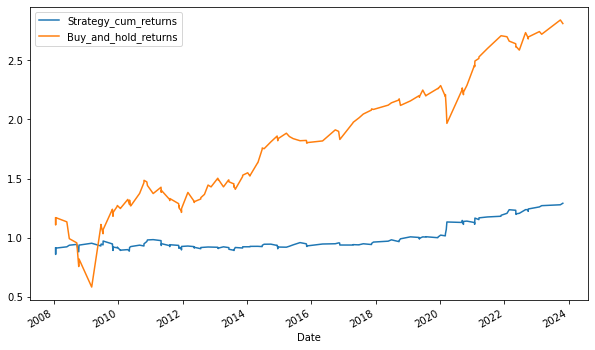

In [5]:
# Trading rules, 
# 1. MACD histogram bar must have fallen 4 days in a row
# 2. The 4th last bar must be below 0
# 3. The current close must be lower than the day before close
# 4. Entry price is the current close
# 5. Exit on the first day when close is higher than the day before close

# 1. MACD histogram bar must have fallen 4 days in a row
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['MACD_signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_diff'] = data['MACD'] - data['MACD_signal']
data['MACD_diff_shift'] = data['MACD_diff'].shift(1)
data['MACD_diff_shift2'] = data['MACD_diff'].shift(2)
data['MACD_diff_shift3'] = data['MACD_diff'].shift(3)
data['MACD_diff_shift4'] = data['MACD_diff'].shift(4)

# Check if the MACD histogram bar has fallen 4 days in a row
data['Fall_4_days'] = np.where((data['MACD_diff_shift'] < data['MACD_diff_shift2']) & (data['MACD_diff_shift2'] < data['MACD_diff_shift3']) & (data['MACD_diff_shift3'] < data['MACD_diff_shift4']), True, False)

# 2. The 4th last bar must be below 0
data['MACD_diff_shift4_below0'] = data['MACD_diff_shift4'] < 0

# 3. The current close must be lower than the day before close
data['Close_shift'] = data['Close'].shift(1) # day before close
data['Close_shift_below'] = data['Close'] < data['Close_shift'] # current close < day before close, True or False

# 4. Entry price is the current close
# If the 4th last bar is below 0 and the current close is lower than the day before close and the MACD histogram bar has fallen 4 days in a row, then enter the trade
data['Entry'] = np.where(data['MACD_diff_shift4_below0'] & data['Close_shift_below'] & data['Fall_4_days'], data['Close'], np.nan) # if True, then Entry = current close, else Entry = NaN

# 5. Exit on the first day when close is higher than the day before close
# If the current close is higher than the day before close, then exit the trade provided we are in the trade
data['Exit'] = np.where((data['Close'] > data['Close_shift']) & (data['Entry'].notnull()), data['Close'], np.nan) # if True, then Exit = current close, else Exit = NaN

# Calculate the returns
data['Returns'] = data['Close'].pct_change() # daily returns
data['Cum_returns'] = (data['Returns'] + 1).cumprod() # cumulative returns

# Calculate the strategy returns
data['Entry_shift'] = data['Entry'].shift(1) # day before entry
data['Strategy_returns'] = np.where(data['Entry_shift'].notnull(), data['Returns'], np.nan) # if Entry_shift is not null, then Strategy_returns = daily returns, else Strategy_returns = NaN
data['Strategy_cum_returns'] = (data['Strategy_returns'] + 1).cumprod() # cumulative returns
print('Strategy returns:', data['Strategy_cum_returns'].iloc[-1]) # strategy returns

# Calculate CAGR
data['Strategy_cum_returns'] = data['Strategy_cum_returns'].replace(1, np.nan) # replace 1 with NaN
data['Strategy_cum_returns'] = data['Strategy_cum_returns'].dropna() # drop NaN
cagr = (data['Strategy_cum_returns'].iloc[-1] / data['Strategy_cum_returns'].iloc[0]) ** (252.0 / len(data.index)) - 1 # CAGR
print('CAGR:', cagr) # CAGR

# Calculate the buy and hold returns
data['Buy_and_hold_returns'] = data['Returns'].cumsum() + 1 # cumulative returns
print('Buy and hold returns:', data['Buy_and_hold_returns'].iloc[-1]) # buy and hold returns

# Calculate the number of days in the market
data['Days'] = data['Strategy_returns'].notnull().astype(int).groupby(data['Strategy_returns'].notnull().astype(int).cumsum()).cumsum() # number of days in the market
print('Number of days in the market:', data['Days'].max()) # maximum number of days in the market

# Calculate the average daily returns
data['Avg_daily_returns'] = data['Strategy_returns'].groupby(data['Strategy_returns'].notnull().astype(int).cumsum()).cumsum() / data['Days'] # average daily returns
print('Average daily returns:', data['Avg_daily_returns'].mean()) # average daily returns

# Calculate the standard deviation of daily returns
data['Std_daily_returns'] = data['Strategy_returns'].groupby(data['Strategy_returns'].notnull().astype(int).cumsum()).cumsum().rolling(2).std() # standard deviation of daily returns
print('Standard deviation of daily returns:', data['Std_daily_returns'].mean()) # average standard deviation of daily returns

# Calculate the Sharpe ratio
Sharp_ratio = data['Avg_daily_returns'] / data['Std_daily_returns'] # Sharpe ratio
print('Sharpe ratio:', Sharp_ratio.mean()) # average Sharpe ratio

# Calculate the maximum drawdown
data['Wealth_index'] = data['Strategy_cum_returns'] # wealth index
data['Previous_peak'] = data['Wealth_index'].cummax() # previous peak
data['Drawdown'] = data['Wealth_index'] - data['Previous_peak'] # drawdown
print('Maximum drawdown:', data['Drawdown'].min()) # maximum drawdown

# Calculate the maximum drawdown duration
data['Drawdown_duration'] = np.where(data['Drawdown'] == 0, 0, 1) # drawdown duration
data['Drawdown_duration'] = data['Drawdown_duration'].groupby(data['Drawdown_duration'].cumsum()).cumsum() # drawdown duration
print('Maximum drawdown duration:', data['Drawdown_duration'].max()) # maximum drawdown duration

# Print all the details
# print(data.head())
# print('#' * 30)
# print(data.tail())
# print('#' * 30)
# print(data.info())

# drop nan values
data = data.dropna(subset=['Strategy_cum_returns'])

# Plot the cumulative returns
data[['Strategy_cum_returns', 'Buy_and_hold_returns']].plot(figsize=(10, 6))



<AxesSubplot:xlabel='Date'>

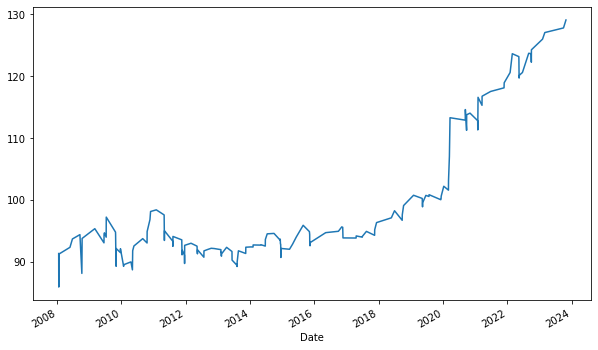

In [6]:
# Plot strategy equity curve if we had invested $100
data['Strategy_equity_curve'] = data['Strategy_cum_returns'] * 100
data['Strategy_equity_curve'].plot(figsize=(10, 6))